# Learning Theory

## Preliminaries

### Imports

In [5]:
import os

import numpy as np
import pandas as pd
import numpy.random as random
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

# for a progress bar on slow calculations
from ipywidgets import IntProgress
from IPython.display import display

%matplotlib inline


### Random Seed

In [8]:
seed=13557
random.seed(seed)

### Data Directory

In [9]:
data_dir="../../data/learningTheory"
if not(os.path.exists(data_dir)):
    os.mkdir(data_dir)

## Learning Problem

### Input and Target Distribution

Data samples $x$ will be real numbers between -1 and 1 so the input space is
$$
    \mathcal{X} = (-1, 1 )
$$
Training examples $x\in\mathcal{X}$ will be chosen with an uniform distribution so that 
$$   X\sim U(-1,1)
$$
and, therefore
$$
    P(x) = \frac{1}{2}
$$

Given $x$, the target variable $y$ will be generated as
$$
    y = f(x) + \epsilon
$$
where f(x) is a sharp peak with support in $(\frac{-1}{4},\frac{1}{4})$

$$
    f(x) = \max\left(0,1-4 |x|\right)
$$
and 
$$
    \epsilon\sim  \sigma(x)\,N(0,1)
$$

with  $\sigma^2(x)=\sigma^2_0(1-x^2)$.

$y$ can take any real value, so
$$
    \mathcal{Y} = \mathbb{R}
$$
and, with those assumptions
$$
    Y|_X \sim N(f(x),\sigma(x))
$$
and
$$
    P(y\mid x) = \frac{1}{\sqrt{2\pi\sigma^2(x)}} e^{-\frac{(y-f(x))^2}{2\sigma^2(x)}}
$$

In [10]:
def f(x):
    return np.maximum(1-np.abs(4*x),0)

The following function generates $N$ training samples $(y_i,x_i)$

In [13]:
def generate_Y(X,sigma):
    Y=f(X)+random.normal(0,sigma,len(X))*np.sqrt(1-X**2)
    return Y

def generate_sample(sigma,N):
    X=random.uniform(-1.0,1.0,N)
    Y=generate_Y(X,sigma)
    return X,Y



### Learning Goal

The goal of learning is to infer $P(y|x)$. 

With our simplifying assumpions about the process, that is equivalent to estimating $f(x)$ and $\sigma$.

### Hypothesis Set

We will search for a function $h$ of the form
$$
    h(x;\theta,\theta')= \theta_0+\sum_{k=1}^{K} \theta_k \cos (k\pi x)+\theta'_k \sin (k\pi x)
$$
so, for fixed $K$, the hypothesis space is
$$
    \mathcal{H}_K = \textrm{span}[1,\cos(\pi x),\sin(\pi x), \cos(2\pi x),\dots,\sin(K\pi x)]
$$

the $1+2K$-dimensional space of linear combinations of trigonometric functions.

For each $K$ we have a **different** hypothesis space. If $K$<$K'$ then $\mathcal{H}_{K} \subset \mathcal{H}_{K'}$ so the hypothesis sets are **nested** and of incresing complexity.

Choosing a function in $\mathcal{H}_K$ is equivalent to choosing the $1+2K$  coefficients $\theta_0$,$\theta_k$,$\theta'_k$ $k=1,\dots K$.

Examples of Functions in $\mathcal{H}_K$

### Error Function

Given our Gaussian assumptions for $Y|_X$ using the negative log likelihood as error function is equivalent to the square error
$$
    E(h,\{y_i,x_i\}) = \frac{1}{N}\sum_i^N ( y_i - h(x_i))^2
$$

### Learning Algorithm

With the Gaussian assumptions the optimal values of $\theta_k$,$\theta'_k$ can be found analytically as a simple linear regression.


In [17]:
np.pi

3.141592653589793

# We will wrap the algo into a class following `sklearn` conventions for convenience

In [19]:
class TrigRegressor:
    
    ##trigonometric regression
    
    def __init__(self,K):
        ## initiate 2 methods: the complexity K and the fitting model -- Linear Regression
        self.K=K
        self.model=LinearRegression(fit_intercept=False) # from sklearn, our model does not have intercept
        
    def H_(self,X): 
        """" Evaluate the basis functions sin( w_k x), cos(w_kx) at each the sample point.
                    
            This is a private function, users of the class do not need to call it directly.
        """
        k=np.arange(0,self.K+1)
        w=np.pi*X[:,np.newaxis]*k[np.newaxis,:] # form product w_{i,k}=\pi * x_i * k
        H1=np.cos(w)
        H2=np.sin(w)
        ## H : [cos(kπx) | sin(kπx)]
        H=np.c_[H1,H2]
        return H
    
    def fit(self,X,Y):
        """ Learning Algorithm (Least Squares Regression) using sklearn API Conventions """
        
        ## from input X generate derived H
        H=self.H_(X)
        
        self.model.fit(H,Y) # use Sklearn for plain vanilla linear regression
        self.coef_=self.model.coef_
        self.intercept_=self.model.intercept_ # should be zero
        return self
    
    def predict(self,X):
        """ returns \hat{h}(X) optimal linear convinations of sin functions"""
        H=self.H_(X)
        return self.model.predict(H) # should be equivalent to np.dot(H,self.coef_)
        

### Test Of Learning Algorightm

#### Choose parameters

In [23]:
sigma = 0.1
N = 100

#### Generate Training Data

In [26]:
X,Y=generate_sample(sigma,N)

Save data 

In [25]:
if False: # change to True to save data
    Xs,Ys=generate_sample(sigma,1000)
    data=pd.DataFrame(np.c_[Xs,Ys],columns=["X","Y"])
    print("Error! We need to save the data!")
    #print(data)
    data.to_csv(data_dir+"/regression_data.csv",index=False)


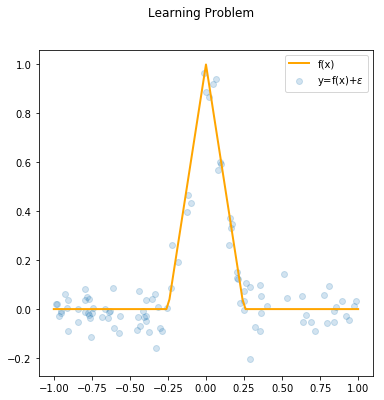

In [10]:
x=np.linspace(-1,1,101) 
fig,axes=plt.subplots(1,1, figsize=(6, 6),sharey=True)
fig.suptitle("Learning Problem")
axes.scatter(X,Y,label="y=f(x)+$\epsilon$",alpha=0.2)
axes.plot(x,f(x),label="f(x)", linewidth=2,color="orange")
axes.legend()

#### Fit (Learn Parameters)

We will use three models of increasing complexity

In [28]:
K0=3
K1=7
K2=25

In [29]:
model0=TrigRegressor(K0)
model1=TrigRegressor(K1)
model2=TrigRegressor(K2)

We compute the basis functions of all the model spaces for plotting

In [31]:
x=np.linspace(-1,1,101) 
h0=model0.H_(x)
h1=model1.H_(x)
h2=model1.H_(x)
h0.shape,h1.shape,h2.shape

((101, 8), (101, 16), (101, 16))

Some possible functions in $H_{K_0}$, $H_{K_1}$ and $H_{K_2}$

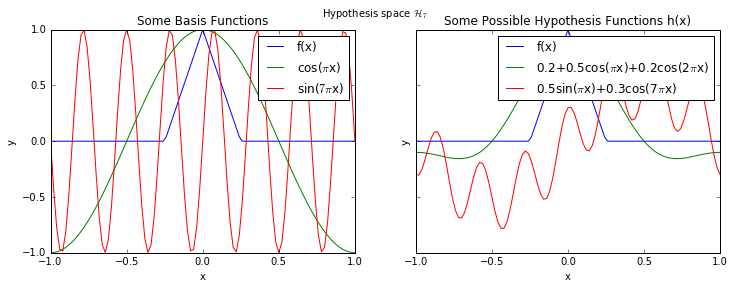

In [32]:
fig,axes=plt.subplots(1,2, figsize=(12, 4),sharey=True)
fig.suptitle("Hypothesis space $\mathcal{H}_7$")
axes[0].set_title("Some Basis Functions")
axes[0].plot(x,f(x),label="f(x)")
axes[0].plot(x,h1[:,1],label="cos($\pi$x)")
axes[0].plot(x,h1[:,15],label="sin($7\pi$x)")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].legend()

axes[1].set_title("Some Possible Hypothesis Functions h(x)")
axes[1].plot(x,f(x),label="f(x)")
axes[1].plot(x,0.2*h1[:,0]+0.5*h1[:,1]+0.2*h1[:,2],label="0.2+0.5cos($\pi$x)+0.2cos(2$\pi$x)")
axes[1].plot(x,0.5*h1[:,9]+0.3*h1[:,7],label="0.5sin($\pi$x)+0.3cos(7$\pi$x)")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
axes[1].legend()

We first Fit the models

In [33]:
model0.fit(X,Y)
model1.fit(X,Y)
model2.fit(X,Y)

And then predict $\hat{h}(x)$ the model's choice for a best fit across $x$'s domain $\mathcal{X}=(-1,1)$

In [34]:
x=np.linspace(-1,1,101) 
y0=model0.predict(x)
y1=model1.predict(x)
y2=model2.predict(x)

Let's compare $f(x)$ and $\hat{h}$ across $\mathcal{X}$

(-0.5, 1.5)

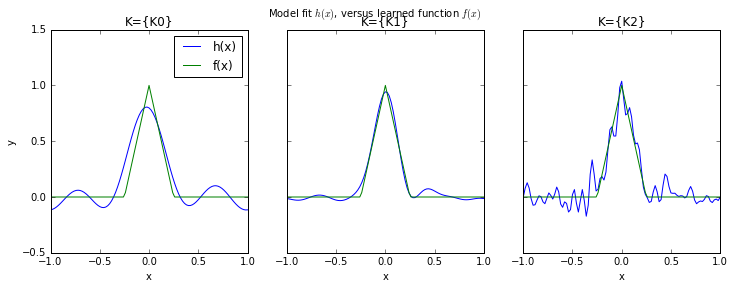

In [36]:
fig,axes=plt.subplots(1,3, figsize=(12, 4),sharey=True)
fig.suptitle("Model fit $h(x)$, versus learned function $f(x)$")
axes[0].plot(x,y0,label="h(x)")
axes[0].plot(x,f(x),label="f(x)")
axes[0].legend()
axes[0].set_title("K={K0}")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(x,y1,label="h(x)")
axes[1].plot(x,f(x),label="f(x)")
axes[1].set_title("K={K1}")
axes[1].set_xlabel("x")
axes[2].plot(x,y2,label="h(x)")
axes[2].plot(x,f(x),label="f(x)")
axes[2].set_xlabel("x")
axes[2].set_title("K={K2}")
axes[0].set_ylim(-0.5,1.5)

### Error Vs Model Complexity

In [37]:
X_test,Y_test=generate_sample(sigma,1000)
Ks=[1,2,3,4,5,7,8,9,10,15,20,25]
train_error=[]
test_error=[]
for K in Ks:
    model=TrigRegressor(K)
    model.fit(X,Y)
    Y_pred=model.predict(X)
    err=np.average((Y_pred-Y)**2)
    ## train error = avg of (y_pred - y_train)^2
    train_error.append(err)
    
    Y_pred=model.predict(X_test)
    test_err=np.average((Y_pred-Y_test)**2)
    ## train error = avg of (y_pred - y_test)^2
    test_error.append(test_err)

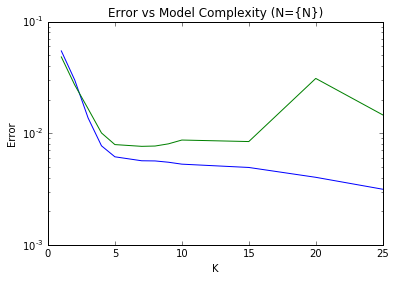

In [39]:
plt.title("Error vs Model Complexity (N={N})")
plt.semilogy(Ks,train_error,label="training error")
plt.semilogy(Ks,test_error,label="test error")
plt.xlabel("K")
plt.ylabel("Error")
#plt.legend()

## Learning Curve

The Learning Curve concerns itself with the difference between training an testing performance as a function of training size.

To avoid getting swamped by the high volatility of overfitted models, we will average error over many trials for a fixed model complexity $K$ and sample size $N$.

In [40]:
R = 100 # number of repeats
Ks=np.array([3,7,25]) # Model Dimension
Ns=np.array([5,10,20,30,40,50,100,150,200,250,300,350,400,450,500,750,1000,1500,2000,3000]) # Training size

Compute
* Training Error
* Testing Error

As a function of training sample size $N$.

We do this for 3 different model complexities $K$

In [41]:
# Avegaring over all the training sessions is slow so we display a progress bar
#    it counts how many training rounds we have done so far
progress = IntProgress(min=0, max=R,description="Trials:",bar_style="success")
display(progress)

train_error_data=np.zeros((R,len(Ks),len(Ns)))
test_error_data=np.zeros((R,len(Ks),len(Ns)))
progress.value=0
for r1 in range(R):
    progress.value+=1
    for k1 in range(len(Ks)):
        K=Ks[k1]
        model=TrigRegressor(K)
        for n1 in range(len(Ns)):
            N=Ns[n1]
            X,Y=generate_sample(sigma,N)
            model.fit(X,Y)
            Y_pred=model.predict(X)
            train_error_data[r1,k1,n1]=np.average((Y_pred-Y)**2)
            X_test,Y_test=generate_sample(sigma,N)
            Y_pred=model.predict(X_test)
            test_error_data[r1,k1,n1]=np.average((Y_pred-Y_test)**2)
print("Done.")

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Done.


In [42]:
train_std=train_error_data.std(axis=0)
train_error=train_error_data.mean(axis=0)
test_std=test_error_data.std(axis=0)
test_error=test_error_data.mean(axis=0)


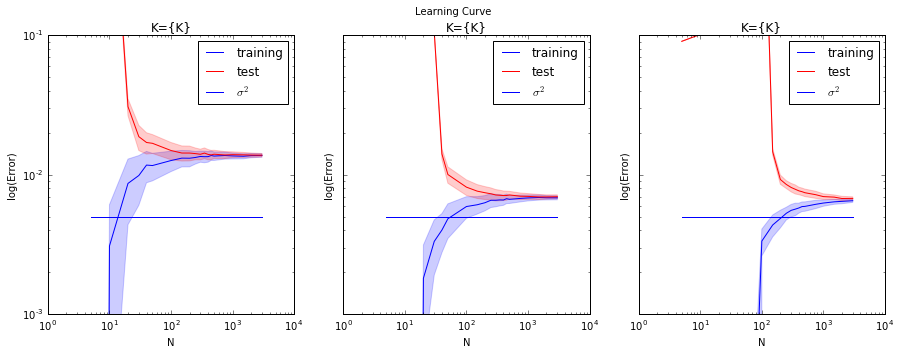

In [44]:
fig,axes=plt.subplots(1,len(Ks), figsize=(15, 5),sharey=True)
plt.suptitle("Learning Curve")
for k1 in range(len(Ks)):
    K=Ks[k1]
    axes[k1].plot(Ns,train_error[k1],label="training",color="b")
    axes[k1].fill_between(Ns,train_error[k1]-train_std[k1],
                             train_error[k1]+train_std[k1],
                          alpha=0.2,color="b")
    axes[k1].plot(Ns,test_error[k1],label="test",color="r")
    axes[k1].fill_between(Ns,test_error[k1]-train_std[k1],
                             test_error[k1]+train_std[k1],
                          alpha=0.2,color="r")
    axes[k1].plot(Ns,[0.5*sigma*sigma]*len(Ns),label="$\sigma^2$")
    #axes[k1].ylim(0,100)
    axes[k1].set_ylim(1e-3,1e-1)
    axes[k1].set_title("K={K}")
    axes[k1].set_xlabel("N")
    axes[k1].set_ylabel("log(Error)")
    axes[k1].set_yscale("log")
    axes[k1].set_xscale("log")
    axes[k1].legend()

We can see that training error converges to test error as sample size $N$ grows.

The rate of convergence is slower for more complex (larger $K$) models.

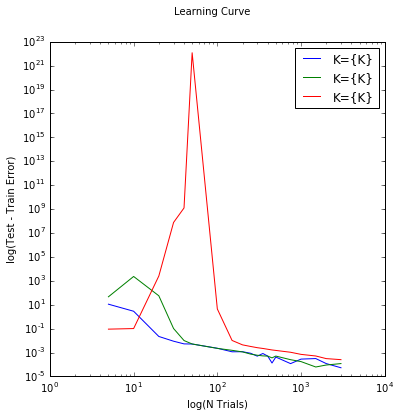

In [46]:
fig,ax=plt.subplots(1,1, figsize=(6, 6))
plt.suptitle("Learning Curve")
for k1 in range(len(Ks)):
    K=Ks[k1]
    ax.plot(Ns,(test_error[k1]-train_error[k1]),label="K={K}")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("log(N Trials)")
    ax.set_ylabel("log(Test - Train Error)")
    ax.legend()

## Bias-Variance Trade Off

### Bias-Variance Decomposition

For a fixed point $x\in\mathcal{X}$ says that the expected mean square error
$$
    \mathbb{E}_{\mathcal{D}}[(\hat{h}(x)-f(x)^2 ]= \sigma_{\epsilon}^2(x) + \textrm{Bias}(x) + \textrm{Variance}(x)
$$
where $\mathbb{E}_{\mathcal{D}} [\cdot]$ is an averaging over all possible classifiers trained from
        random data generated by $P(X)$ and $p(y|x)$. 
And we have that 
$$                            
   \sigma_{\epsilon}^2(x) = \mathbb{E}_{\epsilon}((y-f(x))^2
$$
where the averaging only involve the noise term of $y$ because $p(y|x)$ is independent of the training set
                                                  
$$
   \textrm{Bias}(x) =   (\bar{h}(x) - f(x))^2
$$
is a non-random term where 
$$
    \bar{h}(x)=\mathbb{E}_{\mathcal{D}} [\hat{h}(x)]
$$
is the predicted value of $f(x)$ averaged over all possible training data sets.
                        
And finally
                        
$$
    \textrm{Variance}(x)= \mathbb{E}_{\mathcal{D}} [(\hat{h}(x)- \bar{h}(x))^2]
$$
is the variance of prediction $f(x)$ when computed over all possible training sets.

We will average over training samples. 

To study the trade-off between variance and volatility we will compute the Bias-Variance 
decomposition for a number of model complexities and training sizes.

#### Training Experiments

In [25]:
R = 1000 # number of repeats when averaging over training sets
Ks=np.array([1,2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,35,40]) # Model Dimension
Ns=np.array([100,300,500]) # Training size

We repeat the training experiment R times and collect results for a uniform grid of values in $x\in (-1,1)$ and average over samples.

In [26]:
# Display a progress bar that counts how many training rounds we have done so far
progress2 = IntProgress(min=0, max=R,description="Trials:",bar_style="info")
display(progress2)


#train_error_data=np.zeros((R,len(Ks),len(Ns)))

X_test=np.linspace(-1,1,201)
y_av=np.zeros((len(Ks),len(Ns),len(X_test)))
y_var=np.zeros((len(Ks),len(Ns),len(X_test)))
test_error_data=np.zeros((R,len(Ks),len(Ns),len(X_test)))
train_error_data=np.zeros((R,len(Ks),len(Ns)))

progress2.value=0
for r1 in range(R):
    progress2.value+=1
    for k1 in range(len(Ks)):
        K=Ks[k1]
        model=TrigRegressor(K)
        for n1 in range(len(Ns)):
            N=Ns[n1]
            X,Y=generate_sample(sigma,N)
            model.fit(X,Y)
            Y_pred=model.predict(X)
            train_error_data[r1,k1,n1]=np.average((Y_pred-Y)**2)
            Y_test=generate_Y(X_test,sigma)
            Y_pred=model.predict(X_test)
            test_error_data[r1,k1,n1]=(Y_pred-Y_test)**2
            y_av[k1,n1]+=Y_pred
            y_var[k1,n1]+=Y_pred**2
y_av/=R
y_var/=R
y_var=y_var-y_av**2
test_error=test_error_data.mean(axis=0) 
train_error=train_error_data.mean(axis=0)    
print("Done.")

Widget Javascript not detected.  It may not be installed or enabled properly.


Done.


#### Average Model

Let's look at $\bar{h}(x)$ for a few model complexities $K$s

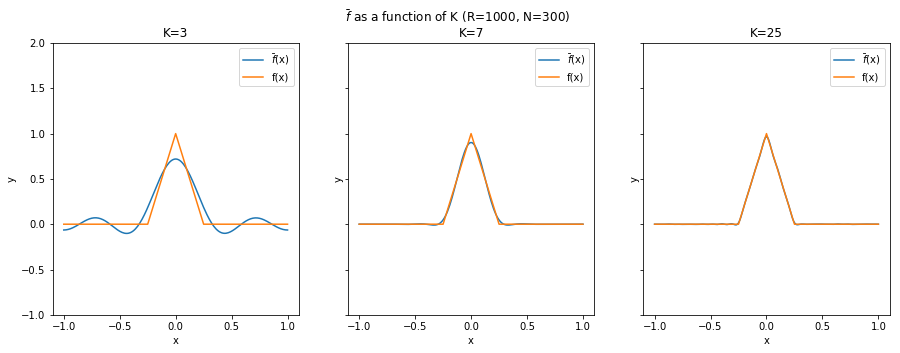

In [27]:
n1=1
N=Ns[n1]
fig,axes=plt.subplots(1,3, figsize=(15, 5),sharey=True)
plt.suptitle(r"$\bar{f}$ as a function of K "+f"(R={R}, N={N})")
for i1,k1 in enumerate([2,6,15]):
    K=Ks[k1]
    axes[i1].plot(X_test,y_av[k1,n1],label=r"$\bar{f}$(x)")
    #axes[i1].plot(X_test,y_av0[k1,n1],label="h0(x)")
    axes[i1].plot(X_test,f(X_test),label="f(x)")
    axes[i1].set_ylim(-1,2)
    axes[i1].set_title(f"K={K}")
    axes[i1].legend()
    axes[i1].set_xlabel("x")
    axes[i1].set_ylabel("y")

#### Bias-Variance Decomposition

Let's compute Bias and Bias + Variance to plot the cumulative error

In [28]:
bias=(f(X_test)-y_av)**2
bias_and_var=bias+y_var

Let's display the Bias-Variance Decomposition 

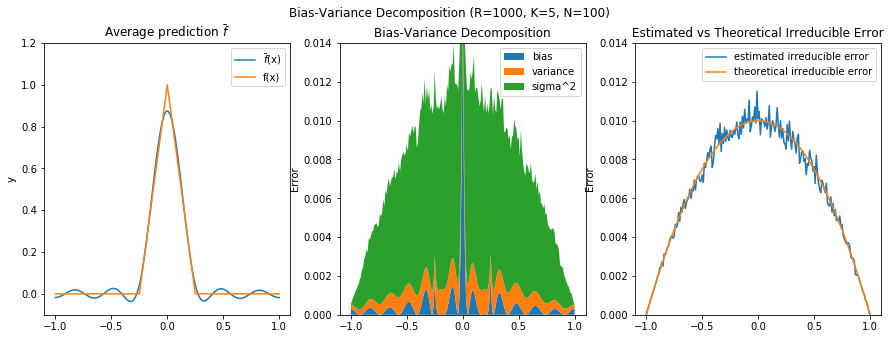

In [29]:
n1=0
k1=4
N=Ns[n1]

K=Ks[k1]

fig,axes=plt.subplots(1,3, figsize=(15, 5),sharey=False)
plt.suptitle(f"Bias-Variance Decomposition (R={R}, K={K}, N={N})")


axes[0].plot(X_test,y_av[k1,n1],label=r"$\bar{f}$(x)")
    #axes[i1].plot(X_test,y_av0[k1,n1],label="h0(x)")
axes[0].plot(X_test,f(X_test),label="f(x)")
axes[0].set_ylim(-0.1,1.2)
axes[0].set_ylabel("y")
axes[0].set_title(r"Average prediction $\bar{f}$")
axes[0].legend()

axes[1].fill_between(X_test,0,bias[k1,n1],label="bias")
axes[1].fill_between(X_test,bias[k1,n1],bias_and_var[k1,n1],label="variance")
axes[1].fill_between(X_test,bias_and_var[k1,n1],test_error[k1,n1],label="sigma^2")
axes[1].set_ylim(0,0.014)
axes[1].set_ylabel("Error")
axes[1].set_title("Bias-Variance Decomposition")
axes[1].legend()

axes[2].plot(X_test,test_error[k1,n1]-bias_and_var[k1,n1],label="estimated irreducible error")
axes[2].plot(X_test,sigma**2*(1-X_test**2),label="theoretical irreducible error")
axes[2].set_ylim(0,0.014)
axes[2].set_ylabel("Error")
axes[2].set_title(f"Estimated vs Theoretical Irreducible Error")
axes[2].legend()

#### Bias-Variance Trade-off

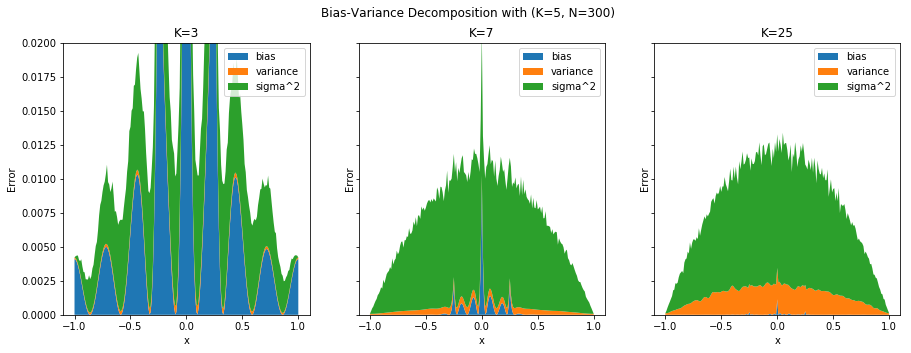

In [30]:
n1=1
N=Ns[n1]
fig,axes=plt.subplots(1,3, figsize=(15, 5),sharey=True)
plt.suptitle(f"Bias-Variance Decomposition with (K={K}, N={N})")
for i1,k1 in enumerate([2,6,15]):
    K=Ks[k1]
    axes[i1].fill_between(X_test,0,bias[k1,n1],label="bias")
    axes[i1].fill_between(X_test,bias[k1,n1],bias_and_var[k1,n1],label="variance")
    axes[i1].fill_between(X_test,bias_and_var[k1,n1],test_error[k1,n1],label="sigma^2")
    axes[i1].set_ylim(0,0.02)
    axes[i1].set_title(f"K={K}")
    axes[i1].set_xlabel("x")
    axes[i1].set_ylabel("Error")
    axes[i1].legend()

#### Residual $\sigma^2$

Given the Bias-Variance Decompositions, the average test error at point $x$ is

$$
     \mathbb{E}_{\mathcal{D}}[(\hat{h}(x)-f(x)^2 ] - \textrm{Bias}(x) -\textrm{Variance}(x) = \sigma_\epsilon^2(z)
$$

Let's plot it

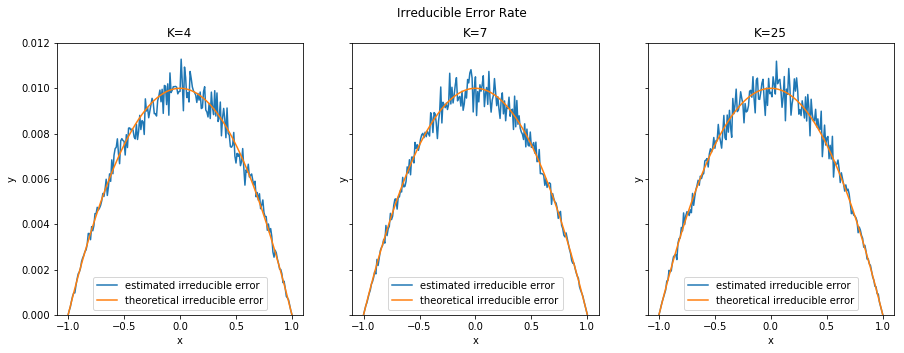

In [31]:

fig,axes=plt.subplots(1,3, figsize=(15, 5),sharey=True)
plt.suptitle("Irreducible Error Rate")
for i1,k1 in enumerate([3,6,15]):
    K=Ks[k1]
    axes[i1].plot(X_test,test_error[k1,n1]-bias_and_var[k1,n1],label="estimated irreducible error")
    axes[i1].plot(X_test,sigma**2*(1-X_test**2),label="theoretical irreducible error")
    axes[i1].set_ylim(0,0.012)
    axes[i1].set_title(f"K={K}")
    axes[i1].set_xlabel("x")
    axes[i1].set_ylabel("y")
    axes[i1].legend()

The results are closes what is expected. 

They do not match exactly because we have computed averages 
over **R = 1000** training sets, not all possible training sets.


### Bias-Variance Trade off

For fixed training size $N$, Bias decreases with model complexity, but variance increases (due to overfitting).

Let's plot Total error versus $K$ for a few training sizes

We now average over all $x$ to provide a summary number, but the trade-off is true point wise.

In [32]:
mean_test_error=test_error.mean(axis=2) # average over all x

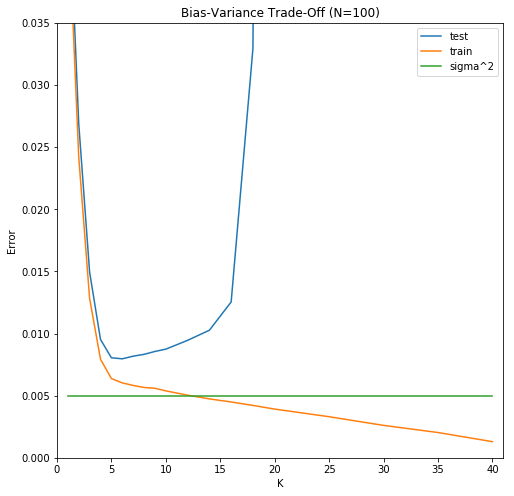

In [33]:
n1=0
N=Ns[n1]
fig,axes=plt.subplots(1,1, figsize=(8, 8),sharey=True)
axes.set_title(f"Bias-Variance Trade-Off (N={N})")

axes.plot(Ks,mean_test_error[:,n1],label="test")
axes.plot(Ks,train_error[:,n1],label="train") 
axes.plot(Ks,[0.5*sigma**2]*len(Ks),label="sigma^2") 
axes.set_ylim(0,0.035)
axes.set_xlim(0,41)
axes.set_xlabel("K")
axes.set_ylabel("Error")
axes.legend()

5 6 0.00796656850189
6 7 0.00721145168302
11 14 0.00708144311015


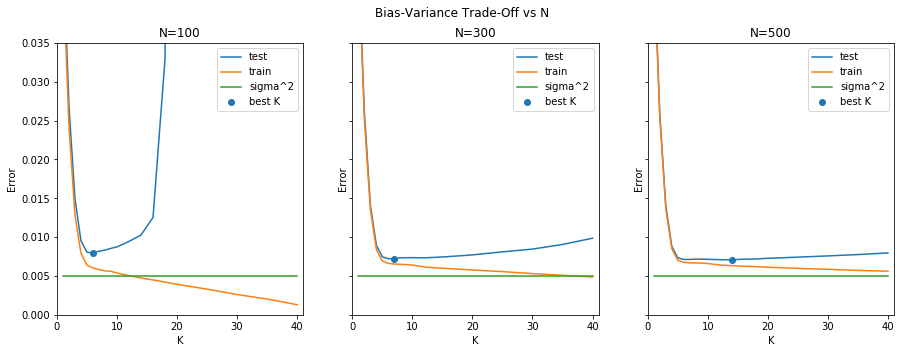

In [34]:
fig,axes=plt.subplots(1,3, figsize=(15, 5),sharey=True)
plt.suptitle("Bias-Variance Trade-Off vs N")
for n1 in range(3):
    best_idx=mean_test_error.argmin(axis=0)[n1]
    best_K=Ks[best_idx]
    best_error=mean_test_error[best_idx,n1]
    print(best_idx,best_K,best_error)
    N=Ns[n1]
    axes[n1].plot(Ks,mean_test_error[:,n1],label="test")
    axes[n1].plot(Ks,train_error[:,n1],label="train") 
    axes[n1].plot(Ks,[0.5*sigma**2]*len(Ks),label="sigma^2") 
    axes[n1].scatter(best_K,best_error,label="best K")
    axes[n1].set_ylim(0,0.035)
    axes[n1].set_xlim(0,41)
    axes[n1].set_xlabel("K")
    axes[n1].set_ylabel("Error")
    axes[n1].set_title(f"N={N}")
    axes[n1].legend()

The best atainable error rate (optimized over all model complexities $K$) improves with training size $N$, but never reaches the base error rate $\sigma^2_\epsilon$

In [35]:
mean_test_error.min(axis=0)

array([ 0.00796657,  0.00721145,  0.00708144])

And, in general, with more training data, more complex modes are preferred as the variance term is 
reduced.

In [36]:
mean_test_error.argmin(axis=0)

array([ 5,  6, 11], dtype=int64)

In [37]:
### Impact of $\sigma^2$

In [38]:
# Display a progress bar that counts how many training rounds we have done so far
progress2 = IntProgress(min=0, max=R,description="Trials:",bar_style="info")
display(progress2)

N=100
Ks=np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,14,16,17,18,19,20]) # Model Dimension
sigmas=[0.0001,0.004,0.01,0.02,0.04,0.06,0.08,0.1,0.15,0.2,0.3,0.4]

X_test=np.linspace(-1,1,201)
y_av=np.zeros((len(sigmas),len(Ks),len(X_test)))
y_var=np.zeros((len(sigmas),len(Ks),len(X_test)))
test_error_data=np.zeros((R,len(sigmas),len(Ks),len(X_test)))
train_error_data=np.zeros((R,len(sigmas),len(Ks)))

progress2.value=0
for r1 in range(R):
    progress2.value+=1
    for k1 in range(len(sigmas)):
        sigma=sigmas[k1]
        for n1 in range(len(Ks)):
            K=Ks[n1]
            #print(r1,sigma,K)
            model=TrigRegressor(K)
            X,Y=generate_sample(sigma,N)
            model.fit(X,Y)
            Y_pred=model.predict(X)
            train_error_data[r1,k1,n1]=np.average((Y_pred-Y)**2)
            Y_test=generate_Y(X_test,sigma)
            Y_pred=model.predict(X_test)
            test_error_data[r1,k1,n1]=(Y_pred-Y_test)**2
            y_av[k1,n1]+=Y_pred
            y_var[k1,n1]+=Y_pred**2
y_av/=R
y_var/=R
y_var=y_var-y_av**2
test_error=test_error_data.mean(axis=0) 
train_error=train_error_data.mean(axis=0)    
print("Done.")

Widget Javascript not detected.  It may not be installed or enabled properly.


Done.


In [39]:
mean_test_error=test_error.mean(axis=2) # average over all x
len(sigmas),len(Ks),mean_test_error.shape,train_error.shape

(12, 20, (12, 20), (12, 20))

14 14 8.69528171462e-05
5 6 0.00153333972307
3 4 0.118451383202


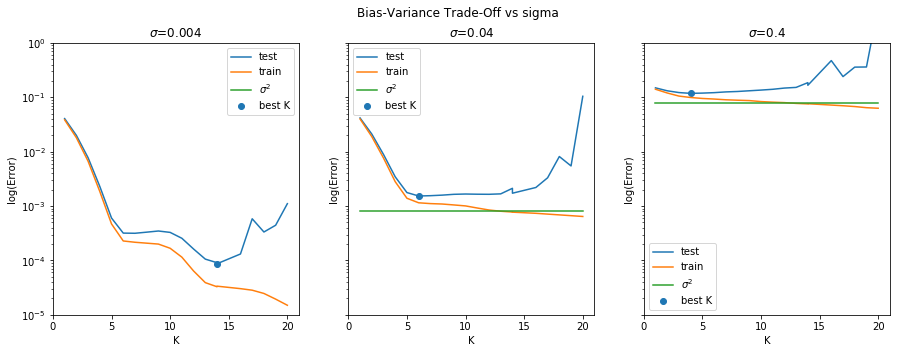

In [40]:
fig,axes=plt.subplots(1,3, figsize=(15, 5),sharey=True)
plt.suptitle("Bias-Variance Trade-Off vs sigma")
for idx,n1 in enumerate([1,4,11]):
    best_idx=mean_test_error.argmin(axis=1)[n1]
    best_K=Ks[best_idx]
    best_error=mean_test_error[n1,best_idx]
    print(best_idx,best_K,best_error)
    sigma=sigmas[n1]
    axes[idx].plot(Ks,mean_test_error[n1,:],label="test")
    axes[idx].plot(Ks,train_error[n1,:],label="train") 
    axes[idx].plot(Ks,[0.5*sigma**2]*len(Ks),label="$\sigma^2$") 
    axes[idx].scatter(best_K,best_error,label="best K")
    axes[idx].set_ylim(1e-5,1)
    axes[idx].set_yscale("log")
    axes[idx].set_xlim(0,21)
    axes[idx].set_xlabel("K")
    axes[idx].set_ylabel("log(Error)")
    axes[idx].set_title(f"$\sigma$={sigma}")
    axes[idx].legend()